In [1]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi, sin
import operator

creator.create("obj", base.Fitness, weights=(-1.0,))

creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'total_pf': {'min': 0.05, 'max': 0.07},
  'sine_a_x': {'min': 0.0, 'max': 2.0},
  'sine_b_x': {'min': 0.0, 'max': 1.57},
  'sine_c_x': {'min': 0.0, 'max': 6.28},
  'sine_a_y': {'min': 0.0, 'max': 2.0},
  'sine_b_y': {'min': 0.0, 'max': 1.57},
  'sine_c_y': {'min': 0.0, 'max': 6.28}},
 'evaluators': {'openmc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc.py'],
   'execute': [['aprun -n 1 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2']],
   'inputs': ['total_pf',
    'sine_a_x',
    'sine_b_x',
    'sine_c_x',
    'sine_a_y',
    'sine_b_y',
    'sine_c_y'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc_keff.py'],
   'outputs': ['total_pf', 'keff']}},
 'constraints': {'keff': {'operator': ['>='], 'constrained_val': [1.38]}},
 'algorithm': {'objective': ['min'],
  'weight': [1.0],
  'optimized_variable': ['total_pf'],
  'pop_size': 128,
  'generations': 3,
  '

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
logbook = cp["logbook"]

In [6]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = logbook.select("gen")
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation [#]", fontsize=22)
    ax.set_ylabel(obj_name + " ("+short_name+") [-]", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([0,1,2])
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=22, bbox_to_anchor = [1.0, 1.0])
    ax.set_title(obj_name + " Evolution", fontsize=24)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

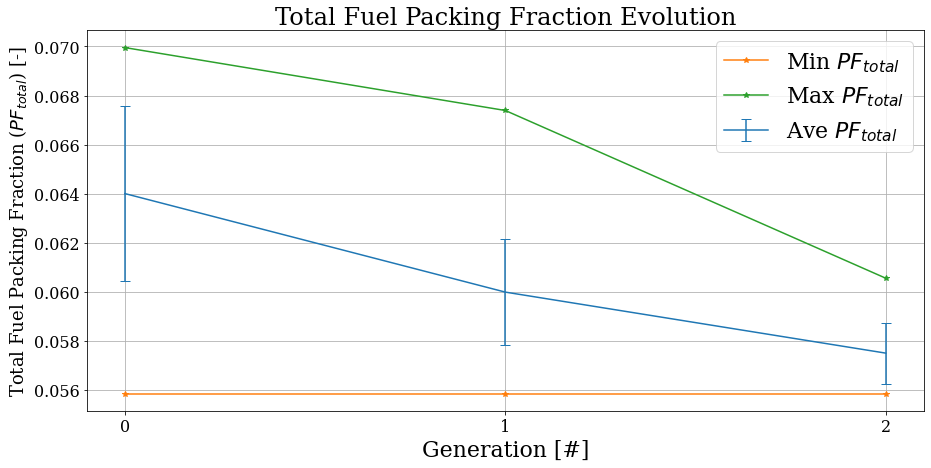

In [7]:
plot_1_obj(logbook, 0, "Total Fuel Packing Fraction", "$PF_{total}$", True, "assem-obj-1-pf-evol.png")

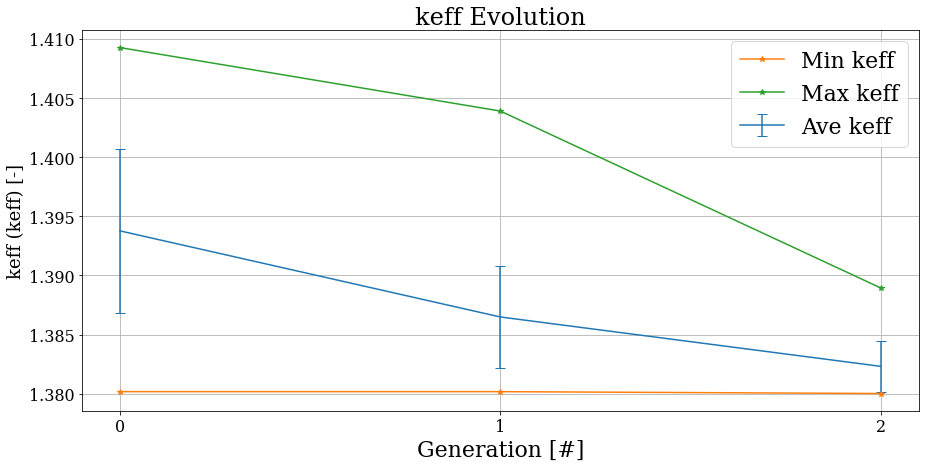

In [8]:
plot_1_obj(logbook, 1, "keff", "keff", False, "")

In [9]:
midpoints_discr_x = np.array([ 6.18871652,  8.22745601, 10.2661955,  12.304935,  14.34367449, 16.38241398,
 18.42115347, 20.45989297, 22.49863246, 24.53737195])
midpoints_discr_y = np.array([19.775, 16.525, 13.275, 10.025,  6.775,  3.525])
def calc_pf_distr(ind, pf_present):
    if pf_present:
        total_pf, sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5], ind[6]
    else:
        sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5]
        total_pf = 0.06
    sine_val_discr_x = sine_a_x * sin(sine_b_x * midpoints_discr_x + sine_c_x) + 2
    sine_val_discr_y = sine_a_y * sin(sine_b_y * midpoints_discr_y + sine_c_y) + 2
    sine_val_distr_xy = sine_val_discr_y.reshape(6,1) * sine_val_discr_x.reshape(1,10) 
    vol_triso = 0.0003181623994807103
    vol_total = 419.3793150536547
    vol_slice = 6.989655250894246
    no_trisos = total_pf * vol_total / vol_triso
    triso_distr = sine_val_distr_xy / sum(sum(sine_val_distr_xy)) * no_trisos
    pf_distr = triso_distr * vol_triso / vol_slice
    return pf_distr

0 125 (0.05585567383573155, 1.3801669466763709)
0.056
[0.05585567383573155, 1.4354659179859126, 1.4884577598358495, 2.3626564115184694, 0.6896429230528118, 0.5841526957065135, 4.170625939304347]
max-min 0.1104277318066042
2 92 (0.057090747098198766, 1.3800104053022173)
0.057
[0.057090747098198766, 1.663849931421477, 1.2575018426090796, 4.6282524463225085, 0.5296361321289116, 0.5529183535105873, 3.7538842262457446]
max-min 0.12099928360802734
1 100 (0.057535819775164324, 1.3813539947312417)
0.058
[0.057535819775164324, 0.6192135058252402, 1.3428984429603266, 3.0855447053340663, 1.67882032715875, 1.287768302273124, 5.635564724808549]
max-min 0.12384167432018456
0 3 (0.058517572507631135, 1.3829516810050322)
0.059
[0.058517572507631135, 1.3714967026370888, 1.0645567657038422, 6.264322339386645, 0.25123600102650934, 0.7984661056247349, 0.6992538376584877]
max-min 0.0837304747027014


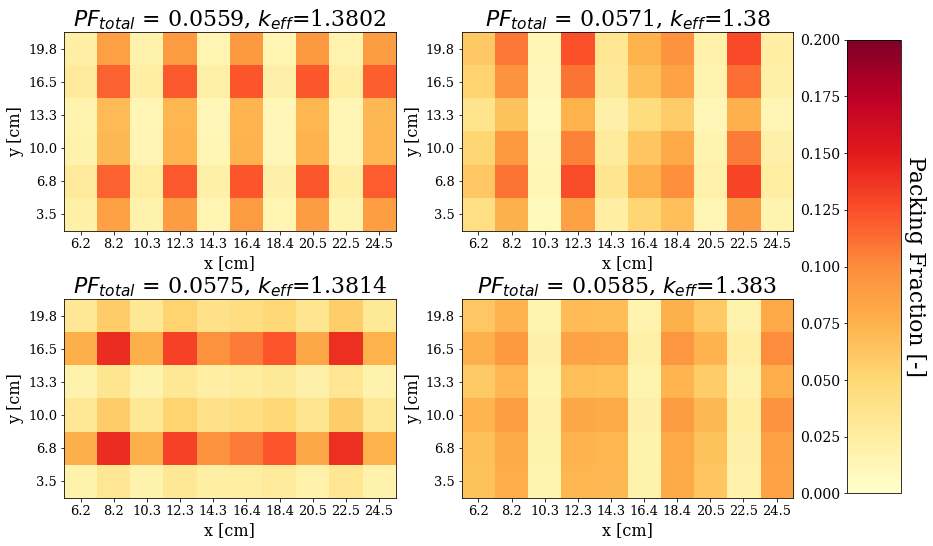

In [10]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
pop = results["populations"][-1]
oup_results = results["outputs"][-1]
obj_0 = np.array([item[0] for item in oup_results])
sorted_index_0 = np.argsort(obj_0)
fig, axes = plt.subplots(figsize=(15,9), nrows=2, ncols=2)
count = 0
old_ppf = 0
for i in sorted_index_0[:128]:
    ind = pop[i]
    new_ppf = round(ind.output[0], 3)
    if new_ppf != old_ppf:
        print(ind.gen, ind.num, ind.output)
        print(new_ppf)
        print(ind)
        old_ppf = new_ppf
        ax = axes.flat[count]
        count += 1
        pf_distr = calc_pf_distr(ind, True)
        im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
        print("max-min",np.amax(pf_distr)-np.amin(pf_distr))
        ax.set_title("$PF_{total}$ = "+str(round(oup_results[i][0],4)) + 
                     ", $k_{eff}$=" + str(round(oup_results[i][1],4)), fontsize=22)
        ax.set_xlabel("x [cm]", fontsize=16)
        ax.set_ylabel("y [cm]", fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=13)
        ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
        ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
        if count == 4:
            break
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=25)
plt.savefig("assem-obj-1-pf-final.png",bbox_inches='tight')

[0.05585567383573155, 1.4354659179859126, 1.4884577598358495, 2.3626564115184694, 0.6896429230528118, 0.5841526957065135, 4.170625939304347]
0.09151054077940317
0.1221296058739214
0.07299736998107728
0.07400631834963926
0.12248906146031022
0.09027019919375895


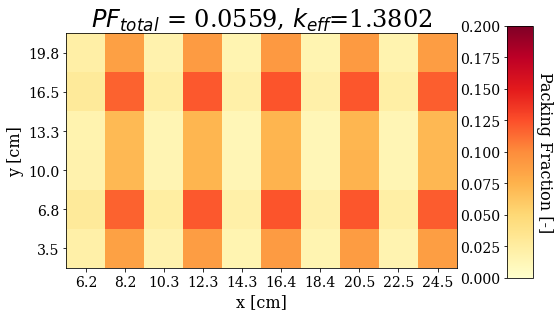

In [11]:
ind_most_minimized = pop[sorted_index_0[0]]
print(ind_most_minimized)
pf_distr = calc_pf_distr(ind_most_minimized, True)
#print(pf_distr)
for row in pf_distr:
    #print(np.max(row)- np.min(row))
    print(np.max(row))
#for i in range(10):
#    col = pf_distr[:, i]
    #print(np.max(col)-np.min(col))
#    print(np.min(col))
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
ax.set_title("$PF_{total}$ = "+str(round(ind_most_minimized.output[0],4))+ ", $k_{eff}$=" + str(round(ind_most_minimized.output[1],4)), fontsize=24)
ax.set_xlabel("x [cm]", fontsize=16)
ax.set_ylabel("y [cm]", fontsize=16)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=14)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=14)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=16, rotation=270, labelpad=20)
plt.savefig("assem-0.0559-most-minimized.png",bbox_inches='tight')

In [12]:
round(np.std(pf_distr), 5)

0.04055

0.0559


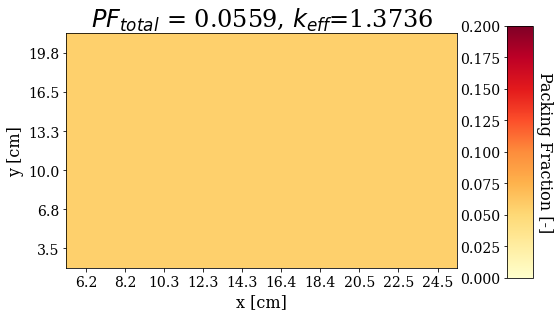

In [13]:
pf_distr = [[0.0559]*10]*6
print(np.amax(pf_distr))
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(pf_distr, vmin=0, vmax=0.2,cmap="YlOrRd")
ax.set_title("$PF_{total}$ = "+str(round(ind_most_minimized.output[0],4)) + ", $k_{eff}$=1.3736", fontsize=24)
ax.set_xlabel("x [cm]", fontsize=16)
ax.set_ylabel("y [cm]", fontsize=16)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=14)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=14)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=16, rotation=270, labelpad=20)
plt.savefig("assem-0.0559-flat.png",bbox_inches='tight')